# Affine Transformation

In [41]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [42]:
im = cv2.imread("../assets/dog.jpeg", 0)

In [43]:
def bilinear_interpolation(im, Y, X):
    X1 = np.int64(np.floor(X))
    Y1 = np.int64(np.floor(Y))
    X2 = np.clip(np.int64(np.ceil(X)), a_min=0, a_max=im.shape[1]-1)
    Y2 = np.clip(np.int64(np.ceil(Y)), a_min=0, a_max=im.shape[0]-1)
    
    LW = np.ceil(X)-X
    RW = 1-LW
    TW = np.ceil(Y)-Y
    BW = 1-TW
    
    XiY1 = im[Y1, X1]*LW + im[Y1, X2]*RW
    XiY2 = im[Y2, X1]*LW + im[Y2, X2]*RW

    return XiY1*TW + XiY2*BW

In [44]:
def extents(T, H, W):
    corners = np.array([[0,0,H-1,H-1],[0,W-1,W-1,0]])

    new_corners = np.dot(T, corners)

    hmin, wmin = np.int64(np.floor(np.min(new_corners, 1)))
    hmax, wmax = np.int64(np.ceil(np.max(new_corners, 1)))

    return hmin,wmin,hmax,wmax,hmax-hmin+1,wmax-wmin+1

In [52]:
def transform(im, T):
    H, W = im.shape[:2]
    ch = 1 if im.ndim == 2 else 3
    hmin, wmin, hmax, wmax, new_h, new_w = extents(T, H, W)

    new_im = np.squeeze(np.zeros((new_h, new_w, ch), dtype=np.uint8))

    YY, XX = np.mgrid[hmin:hmax+1, wmin:wmax+1]
    pts = np.r_[[np.ravel(YY), np.ravel(XX)]]
    new_pts = np.dot(np.linalg.inv(T), pts).astype(int)

    valid_idx = np.logical_and(
        np.logical_and(new_pts[0,:]<H, new_pts[1,:]<W),
        np.logical_and(new_pts[0,:]>=0,new_pts[1,:]>=0)
    )

    Y_, X_ = np.vsplit(pts[:,valid_idx], 2)
    Y, X = np.vsplit(new_pts[:,valid_idx], 2)

    new_im[Y_-Y_.min(), X_-X_.min()] = bilinear_interpolation(im, Y, X)
    return np.squeeze(new_im)

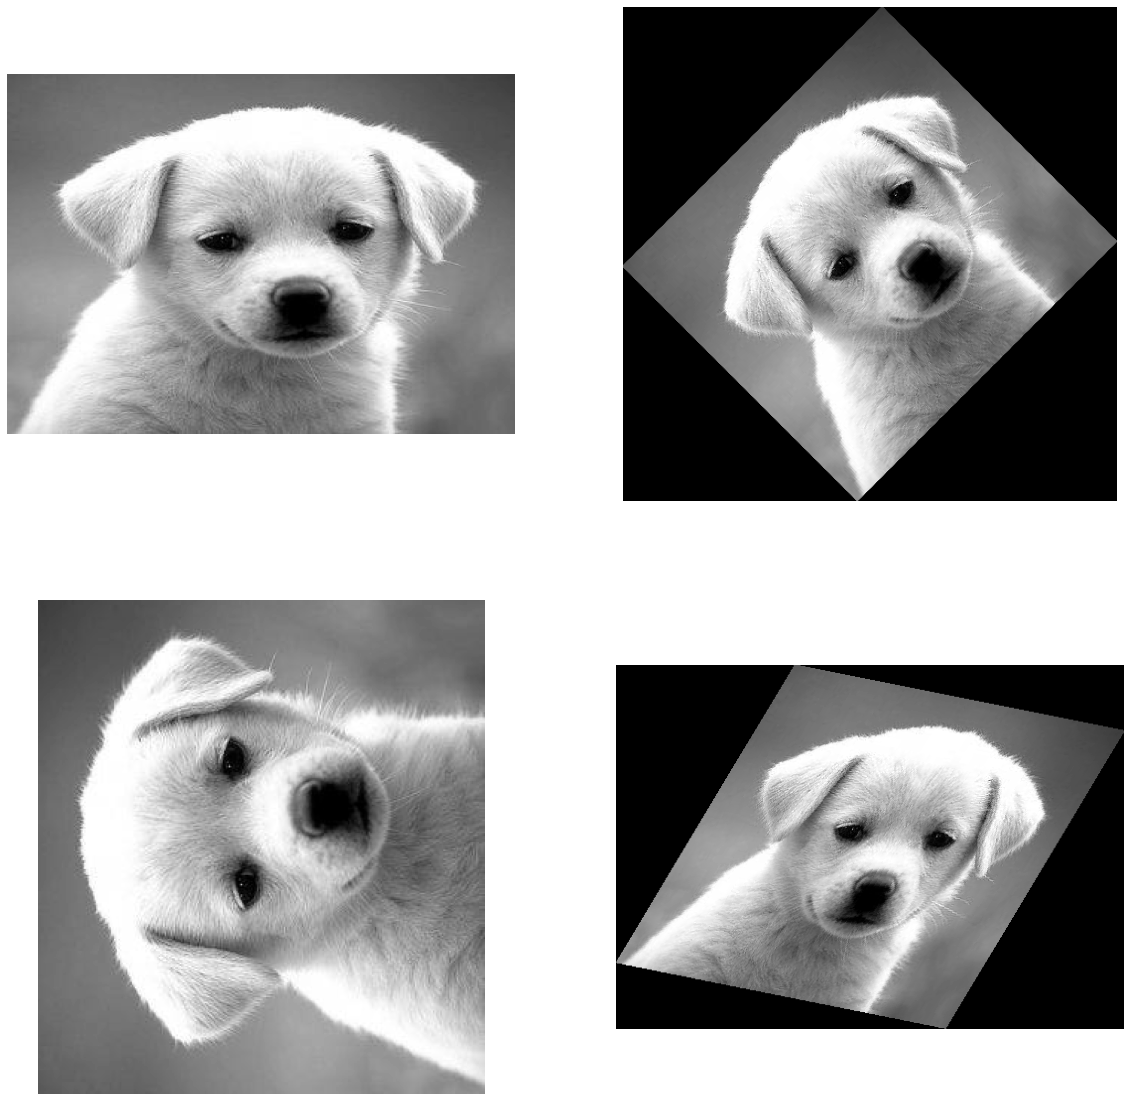

In [53]:
fig = plt.figure(figsize=(20, 20))

# Scaling Matrix (2x2)
S = np.array([[2.2,  0],
              [  0,2.8]])

# Rotation Matrix (2x2)
theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
R = np.array([[c, -s],
              [s,  c]])

# Reflection Matrix (2x2)
Rf = np.array([[0, -1],
               [1,  0]])

# Shear Matrix (2x2)
Sh = np.array([[   1,0.2],
               [-0.6,  1]])

Ts = [S, R, Rf, Sh]
for i, T in enumerate(Ts,1):
    fig.add_subplot(2, 2, i)
    plt.imshow(transform(im, T), cmap='gray')
    plt.axis('off')
plt.show()

# Projective Transformation

In [47]:
def extents_projective(T, H, W):
    corners = np.array([[0,0,H-1,H-1],[0,W-1,W-1,0],[1,1,1,1]])

    new_corners = np.dot(T, corners)
    new_corners = np.divide(new_corners, new_corners[2,:])[:2]

    hmin, wmin = np.int64(np.floor(np.min(new_corners, 1)))
    hmax, wmax = np.int64(np.ceil(np.max(new_corners, 1)))

    return hmin,wmin,hmax,wmax,hmax-hmin+1,wmax-wmin+1

In [48]:
def transform_projective(im, T):
    H, W = im.shape[:2]
    ch = 1 if im.ndim == 2 else 3
    hmin, wmin, hmax, wmax, new_h, new_w = extents_projective(T, H, W)
    new_im = np.squeeze(np.zeros((new_h, new_w, ch), dtype=np.uint8))
    
    YY, XX = np.mgrid[hmin:hmax+1, wmin:wmax+1]
    
    pts = np.r_[[np.ravel(YY), np.ravel(XX), np.repeat(1, XX.size)]]
    new_pts = np.dot(np.linalg.inv(T), pts)

    pts = pts[:2]
    new_pts = np.int64(np.round(np.divide(new_pts, new_pts[2,:])[:2]))

    valid_idx = np.logical_and(
        np.logical_and(new_pts[0,:]<H, new_pts[1,:]<W),
        np.logical_and(new_pts[0,:]>=0,new_pts[1,:]>=0)
    )

    Y_, X_ = np.vsplit(pts[:,valid_idx], 2)
    Y, X = np.vsplit(new_pts[:,valid_idx], 2)

    new_im[Y_-Y_.min(), X_-X_.min()] = bilinear_interpolation(im, Y, X)
    return np.squeeze(new_im)

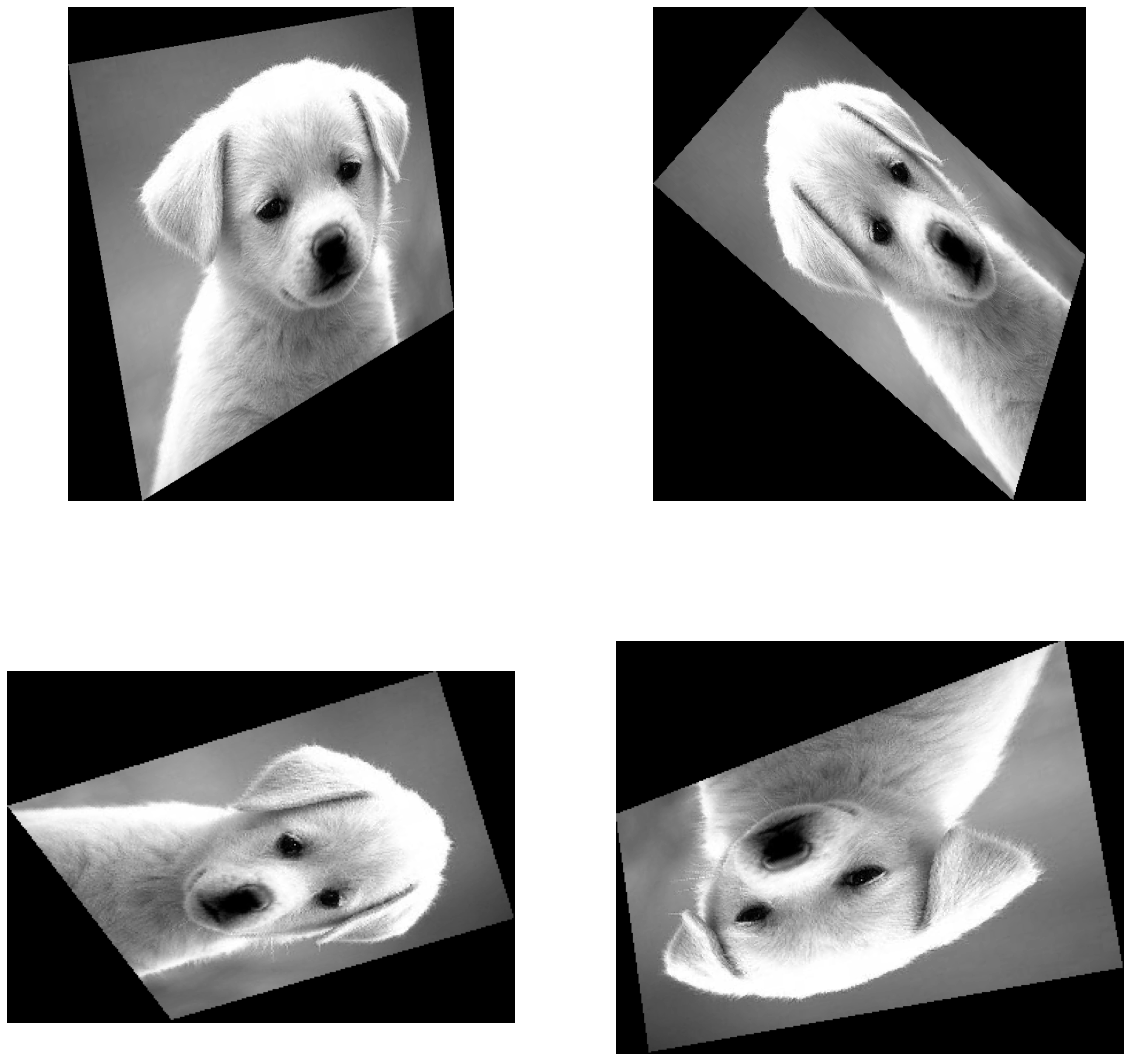

In [60]:
fig = plt.figure(figsize=(20, 20))

for i in range(1,5):
    theta = np.random.randint(-100, 100)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c,-s, 0],
                  [s, c, 0],
                  [0, 0, 1]])
    fy, fx = np.random.randint(8, 15, 2)/10
    S = np.array([[fy, 0, 0],
                  [0, fx, 0],
                  [0,  0, 1]])
    k = np.random.standard_normal()
    Sh = np.array([[fy,0, 0],
                  [0, fx, 0],
                  [0,  0, 1]])
    ty, tx =  np.random.randint(-100, 100, 2)
    T = np.array([[1, 0, ty],
                  [0, 1, tx],
                  [0, 0, 1]])
    
    P = np.array([[1, 0, 0],
                  [0, 1, 0],
                  [fy/10000, fx/1000, 1]])
    
    H = R.dot(S).dot(Sh).dot(T).dot(P)
    fig.add_subplot(2, 2, i)
    plt.imshow(transform_projective(im, H), cmap='gray')
    plt.axis('off')
plt.show()